In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets
from scipy.optimize import fsolve
from scipy import linalg
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import msclib
import pandas as pd
import networkx as nx

In [2]:
class ARNN(object):
    """
    Implementation of an adaptive recurrent neural network (ARNN).
    
    """
    
    def __init__(self, N, eps, eta, I, A):   
    
        # Create input layer.
        self.N = N
        self.eps = eps 
        self.eta = eta
        self.I = I
        self.A = A

    
    def f(self, t, x):
        """
        Vector field giving dynamics of ARNN.

        Parameters
        ----------
        

        Returns
        -------
        Nd array
            Value of function giving dynamics for given values.

        """
        # Split input vector into node states and matrix components
        r = x[0:N]
        M = x[N:]
        M.resize((self.N, self.N))
        
        # Compute output of vector field giving dynamics, then resize into 
        # output vector of length N + N**2
        r_next = 1/self.eps*(-r + np.tanh(M.dot(r) + self.I(t)))
        
        rTr = np.asarray([r]).T@np.asarray([r])
        M_next = self.eta*np.multiply(self.A, rTr) - np.multiply(np.abs(self.A), M)
        np.fill_diagonal(M_next, 0)
        M_next = M_next.flatten()
        
        return np.concatenate((r_next, M_next))
    
    
    def evolve(self, r0, M0, t_span, num_steps):
        M0 = M0.flatten()
        x0 = np.concatenate((r0, M0))
        sln = solve_ivp(self.f, t_span, x0, dense_output=True)
        t = np.linspace(t_span[0], t_span[1], num_steps)
        return (sln.sol(t), t)

In [3]:
def plot_grid(r, t, ms, m, n, figsize, ylim=1.1):
    fig=plt.figure(figsize=figsize)
    gs=GridSpec(m,n, wspace=0.3) # 3 rows, 3 columns
    
    axes = []
    
    for i in range(m):
        for j in range(n):
            axes.append(fig.add_subplot(gs[i,j]))

    [axes[i].plot(t, r[i])  for i in range(m*n)]
    [axes[i].plot([t[0], t[-1]], [msclib.r_plus(ms), msclib.r_plus(ms)], 'r-') for i in range(m*n)]
    [axes[i].plot([t[0], t[-1]], [-msclib.r_plus(ms), -msclib.r_plus(ms)], 'r-')  for i in range(m*n)]
    [axes[i].set_ylim(-ylim, ylim)  for i in range(m*n)]
    [axes[i].set_xlabel('t', fontsize=20)  for i in range(m*n)]
    
    
def t_switch(r, t):
    symbols = np.sign(r[:,t[0]:t[1]])
    switches = ((np.roll(symbols, 1, axis=1) - symbols) !=0).astype(int)
    switches[:,0] = 0
    switch_times = [np.nonzero(switches[i])[0] for i in range(r.shape[0])]
    inter_switch_times = [(switch_times[i] - np.roll(switch_times[i],1))[1:] for i in range(r.shape[0])]
    return (switch_times, inter_switch_times) 


def classify_nodes(inter_switch_times, dt, tol):
    indices = list(range(len(inter_switch_times)))
    stationary = []
    periodic = []
    
    for i in indices:
        if len(inter_switch_times[i]) == 0:
            stationary.append(i)
            
    [indices.remove(i) for i in stationary]
            
    for i in indices:
        if dt*(np.std(inter_switch_times[i])) < tol:
            periodic.append(i)
            
    [indices.remove(i) for i in periodic]
            
    return {'stationary': stationary, 'periodic': periodic, 'aperiodic': indices}  

def freq_clusters(indices, inter_switch_times, dt, tol):
    periods = {i: dt*np.mean((inter_switch_times[i] + np.roll(inter_switch_times[i], 1))[1:]) for i in indices}

    G=nx.Graph()
    G.add_nodes_from(periods.keys(), labels=True)
    for key,n in G.nodes.items():
        n["period"] = periods[key]
        
    
    
    for node_r, attributes_r in G.nodes(data=True):
        G.add_edges_from([(node_r, node) for node, attributes in G.nodes(data=True)
                          if np.abs(attributes_r['period'] - attributes['period']) < tol
                          and node != node_r])
    
    return (periods, G)
    

In [21]:
dt = 100/200000
(switch_times, inter_switch_times) = t_switch(trajectories[6], [100000, 150000])
node_types = classify_nodes(inter_switch_times, dt, 0.1)
periods, G = freq_clusters(node_types['periodic'], inter_switch_times, dt, 0.01)

In [22]:
dt = 100/200000
(switch_times, inter_switch_times) = t_switch(trajectories[6], [100000, 150000])

In [27]:
switch_times[4][0]

159

In [100]:
node_types = classify_nodes(inter_switch_times, dt, 0.1)

In [101]:
node_types['stationary'], node_types['periodic'], node_types['aperiodic']

([0, 1, 2], [3, 4, 5, 6, 7, 8], [])

In [102]:
periods, G = freq_clusters(node_types['periodic'], inter_switch_times, dt, 0.01)

In [103]:
periods

{3: 1.7748653846153846,
 4: 1.5134193548387098,
 5: 1.774096153846154,
 6: 2.209690476190476,
 7: 1.5134354838709678,
 8: 2.205725}

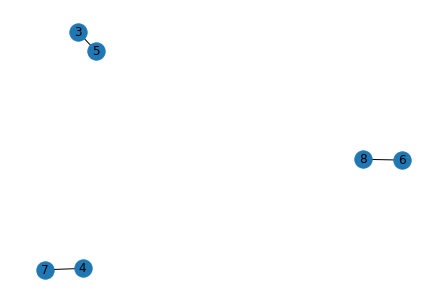

In [106]:
nx.draw(G, with_labels=True)

In [111]:
G.nodes[3]['period']

1.7748653846153846

In [133]:
frequency_clusters = []

for comp in nx.connected_components(G):
    mean_period = np.mean([G.nodes[i]['period'] for i in comp])
    frequency_clusters.append((mean_period, list(comp)))

frequency_clusters = sorted(frequency_clusters, key=lambda x: (x[0],x[1]), reverse=True)

In [134]:
frequency_clusters

[(2.2077077380952383, [8, 6]),
 (1.7744807692307694, [3, 5]),
 (1.513427419354839, [4, 7])]

In [120]:
l = sorted(l,key=lambda x: (x[0],x[1]))

In [121]:
l

[(1.513427419354839, {4, 7}),
 (1.7744807692307694, {3, 5}),
 (2.2077077380952383, {6, 8})]

In [64]:
for node, attributes in G.nodes(data=True):
    print(node, attributes)

3 {'period': 1.7748653846153846}
4 {'period': 1.5134193548387098}
5 {'period': 1.774096153846154}
6 {'period': 2.209690476190476}
7 {'period': 1.5134354838709678}
8 {'period': 2.205725}


In [248]:
(switch_times, inter_switch_times) = t_switch(trajectories[6], [100000, 150000])

In [ ]:
freq

In [231]:
switch_times[3]

array([ 1750,  3494,  5329,  7063,  8851, 10681, 12395, 14218, 15957,
       17684, 19517, 21252, 23064, 24843, 26579, 28391, 30119, 31900,
       33667, 35458, 37297, 39023, 40807, 42569, 44299, 46154, 47894,
       49680], dtype=int64)

In [238]:
np.std(inter_switch_times[3])*dt

0.020945713358424402

In [246]:
inter_switch_times[3]

array([1744, 1835, 1734, 1788, 1830, 1714, 1823, 1739, 1727, 1833, 1735,
       1812, 1779, 1736, 1812, 1728, 1781, 1767, 1791, 1839, 1726, 1784,
       1762, 1730, 1855, 1740, 1786], dtype=int64)

In [233]:
inter_switch_times[3], max(inter_switch_times[3]), min(inter_switch_times[3]) 

(array([1744, 1835, 1734, 1788, 1830, 1714, 1823, 1739, 1727, 1833, 1735,
        1812, 1779, 1736, 1812, 1728, 1781, 1767, 1791, 1839, 1726, 1784,
        1762, 1730, 1855, 1740, 1786], dtype=int64),
 1855,
 1714)

In [144]:
len(switch_times[0][0])

0

In [133]:
r_test = trajectories[2, 7:9]
(switch_times, inter_switch_times) = solution_phase(r_test, [100000, 150000])

In [134]:
switch_times

[(array([  441,  1254,  2066,  2879,  3692,  4504,  5317,  6129,  6942,
          7755,  8567,  9380, 10193, 11005, 11818, 12630, 13443, 14256,
         15068, 15881, 16693, 17506, 18319, 19131, 19944, 20756, 21569,
         22382, 23194, 24007, 24820, 25632, 26445, 27257, 28070, 28883,
         29695, 30508, 31320, 32133, 32946, 33758, 34571, 35383, 36196,
         37009, 37821, 38634, 39446, 40259, 41072, 41884, 42697, 43509,
         44322, 45135, 45947, 46760, 47573, 48385, 49198], dtype=int64),),
 (array([   35,   848,  1660,  2473,  3285,  4098,  4911,  5723,  6536,
          7348,  8161,  8974,  9786, 10599, 11411, 12224, 13037, 13849,
         14662, 15475, 16287, 17100, 17912, 18725, 19538, 20350, 21163,
         21975, 22788, 23601, 24413, 25226, 26038, 26851, 27664, 28476,
         29289, 30101, 30914, 31727, 32539, 33352, 34164, 34977, 35790,
         36602, 37415, 38227, 39040, 39853, 40665, 41478, 42291, 43103,
         43916, 44728, 45541, 46354, 47166, 47979, 48791, 496

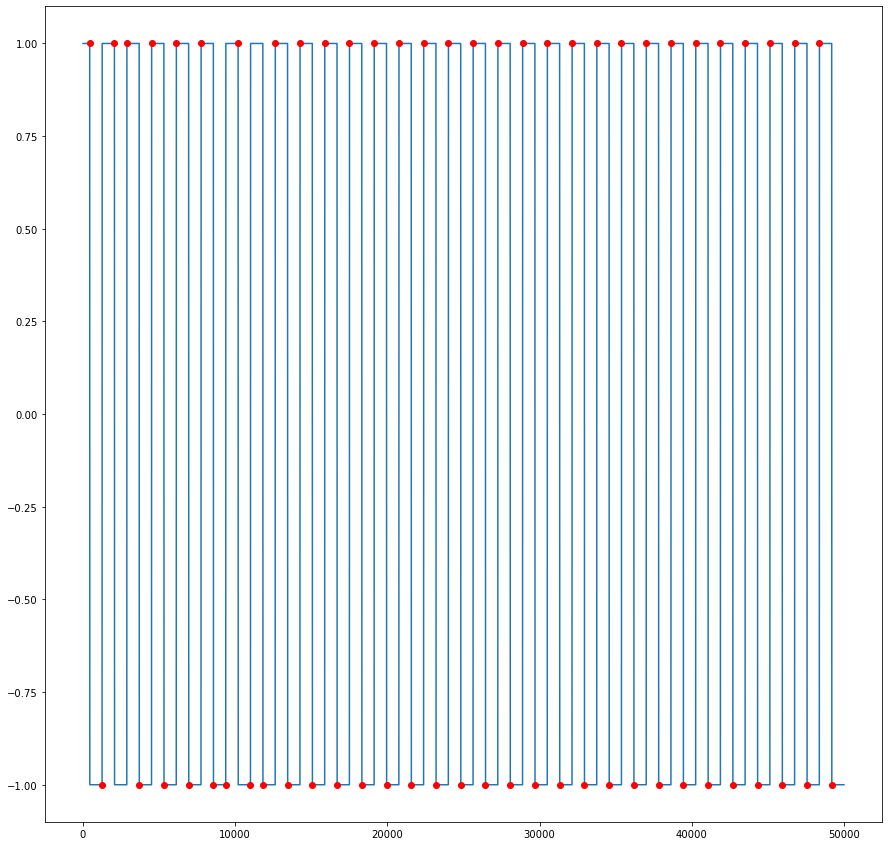

In [135]:
fig, ax = plt.subplots(figsize=(15, 15))
r_test2 = np.sign(r_test)
ax.plot(r_test2[0,100000:150000])
ax.plot(switches[0], r_test2[0, switch_times[0]], 'ro')


In [136]:
(switches[0] - np.roll(switches[0],1))[0,1:]

array([813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 813, 812,
       813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 812, 813,
       813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 812, 813,
       813, 812, 813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813,
       812, 813, 813, 812, 813, 813, 812, 813], dtype=int64)

In [137]:
(switches[1] - np.roll(switches[1],1))[0,1:]

array([813, 812, 813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813,
       812, 813, 813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813,
       812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 812, 813, 813,
       812, 813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 813,
       812, 813, 812, 813, 813, 812, 813, 812, 813], dtype=int64)

In [138]:
inter_switch_times

[array([813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 813, 812,
        813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 812, 813,
        813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 812, 813,
        813, 812, 813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813,
        812, 813, 813, 812, 813, 813, 812, 813], dtype=int64),
 array([813, 812, 813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813,
        812, 813, 813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813,
        812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 812, 813, 813,
        812, 813, 812, 813, 813, 812, 813, 812, 813, 813, 812, 813, 813,
        812, 813, 812, 813, 813, 812, 813, 812, 813], dtype=int64)]

In [108]:
r_test2[0,switches[0]]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [103]:
switches[0]

(array([  441,  1254,  2066,  2879,  3692,  4504,  5317,  6129,  6942,
         7755,  8567,  9380, 10193, 11005, 11818, 12630, 13443, 14256,
        15068, 15881, 16693, 17506, 18319, 19131, 19944, 20756, 21569,
        22382, 23194, 24007, 24820, 25632, 26445, 27257, 28070, 28883,
        29695, 30508, 31320, 32133, 32946, 33758, 34571, 35383, 36196,
        37009, 37821, 38634, 39446, 40259, 41072, 41884, 42697, 43509,
        44322, 45135, 45947, 46760, 47573, 48385, 49198, 50010, 50823,
        51636, 52448, 53261, 54073, 54886, 55699, 56511, 57324, 58136,
        58949, 59762, 60574, 61387, 62200, 63012, 63825, 64637, 65450,
        66263, 67075, 67888, 68700, 69513, 70326, 71138, 71951, 72763,
        73576, 74389, 75201, 76014, 76827, 77639, 78452, 79264, 80077,
        80890, 81702, 82515, 83327, 84140, 84953, 85765, 86578, 87390,
        88203, 89016, 89828, 90641, 91453, 92266, 93079, 93891, 94704,
        95517, 96329, 97142, 97954, 98767, 99580], dtype=int64),)

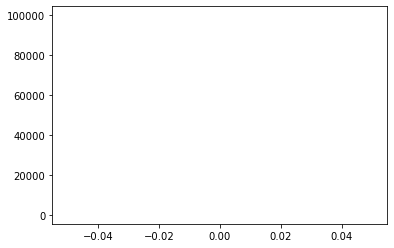

In [97]:
plt.plot(switches[0])

In [87]:
arr = np.array([[4, 0, 0], [0, 6, 0], [-7, 15, 0]])
arr2 = np.nonzero(arr)
arr2

(array([0, 1, 2, 2], dtype=int64), array([0, 1, 0, 1], dtype=int64))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
neg = ax.imshow(np.sign(r_test[:,100000:200000]), vmin=-1, vmax=1, cmap='viridis',aspect='auto', interpolation='none')
fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
yticks = np.arange(0, 2)
ax.set_yticks(yticks)
ax.set_yticklabels([1, 2])
plt.yticks(fontsize=20)
ax.set_xticks([0, 20000, 40000, 60000, 80000, 100000])
ax.set_xticklabels([50, 60, 70, 80, 90, 100])
plt.xticks(fontsize=20)
ax.set_ylabel('Node index', fontsize=20)
ax.set_xlabel('t', fontsize=20)

In [79]:
switches


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [73]:
a = [1, -1, -1, 1, -1]
switches = ((np.roll(a, 1) - a) !=0).astype(int)
switches[0] = 0
switches

array([0, 1, 0, 1, 1])

# Set Network Paramaters:

In [48]:
# Network paramsa
# Number of nodes
N = 9

# learning rate
eta = 1/(N-1)

# Timescale separation param
eps=0.01

# Inputs
I = np.zeros(N)
I_t = lambda t: I

# Self weights
m = 1.1

In [49]:
input_range = eta*(N-1)
a = msclib.I(msclib.r_plus(m), m)
b = msclib.I(-msclib.r_plus(m), m)

input_range, msclib.r_plus(m), a, b, b-a

(1.0,
 0.30151134457776374,
 -0.02048122717815065,
 0.020481227178150707,
 0.04096245435630136)

# Set matrix specifying which synapses are hebbian or anti-hebbian

In [50]:
# All to all coupling adjacency matrix, with 0 diagonal to prevent self weights from updating.
A = np.random.choice([-1, 1], N**2, p=[1, 0])
A.resize(N, N)
np.fill_diagonal(A, 0)

# Create ARNN instance

In [51]:
ad_net = ARNN(N, eps, eta, I_t, A)

# Set initial conditions

In [99]:
np.random.seed(2)
# Initial node states.
r0 = np.random.uniform(low=-1, high=1, size=N)
#r0 = np.random.choice([-1, 1], N, p=[1, 0])

# Initial Matrix values.
M0 = np.random.uniform(low=-eta, high=eta, size=N**2)
M0.resize(N, N)

# Make diagonal entries equal to m.
ind = np.diag_indices_from(M0)
M0[ind] = m

In [100]:
t_span = [0, 200]
num_steps = 400000
sln, t = ad_net.evolve(r0, M0, t_span, num_steps)

In [101]:
r = sln[0:N]
M_vector = sln[N:].T

M = np.zeros((num_steps, N, N))

for i in range(num_steps):
    M[i,:,:] = np.reshape(M_vector[i], (N, N))

In [102]:
eta

0.125

In [103]:
np.max(np.abs(M[:, 1, 2:]))*(N-1)

0.8694269912262438

In [104]:
np.max(np.abs(M[:, 1, 0])), np.max(np.abs(M[:, 1, 2:]))

(0.086640371339367, 0.10867837390328047)

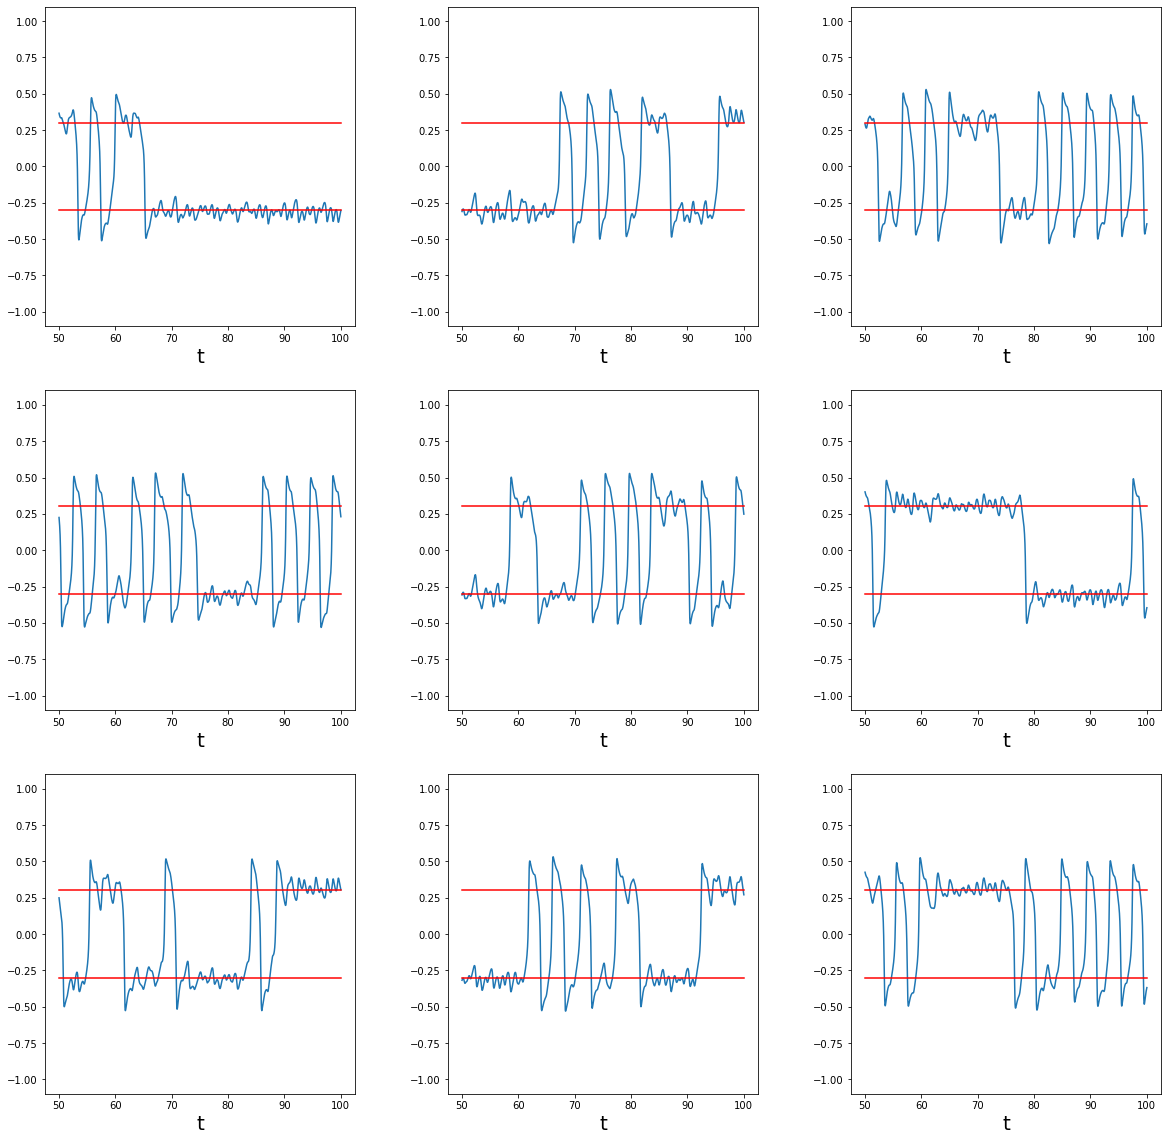

In [105]:
fig = plot_grid(r[:,100000:200000], t[100000:200000], m, 3, 3, (20, 20), ylim=1.1)

In [94]:
# synch measures
# 1) corellation in time
# 2) , 

# Network plotting software
# cytoscape. software package for visualizing graphs. Has python interface and plugin. Think it runs in java?
# graphviz 
# in networkx, can introduce different 'gravity' effects.

In [95]:
@widgets.interact(a=(0, 9, 1), b=(0, 9, 1),
                  c=(0, 9, 1), d=(0, 9, 1),
                  e=(0, 9, 1), f=(0, 9, 1), 
                  g=(0, 9, 1), h=(0, 9, 1),
                  i=(0, 9, 1))
def update(a=0, b=1, c=2, d=3, e=4, f=5, g=6, h=7, i=8):
    fig, ax = plt.subplots(figsize=(10, 10))
    r_perm = r[[a, b, c, d, e, f, g, h, i]]
    neg = ax.imshow(r_perm, vmin=-0.7, vmax=0.7, cmap='RdBu',aspect='auto', interpolation='none')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    yticks = np.arange(0, 9)
    ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.yticks(fontsize=10)
    ax.set_yticks(yticks)

interactive(children=(IntSlider(value=0, description='a', max=9), IntSlider(value=1, description='b', max=9), …

# Proportion of Anti-Hebbian Synapses

In [106]:
%%time
trajectories_long = np.zeros((N+1, N, num_steps))

for i in range(N+1):
    A = np.ones((N, N))
    A[N-i:] = -A[N-i:]
    np.fill_diagonal(A, 0)
    ad_net = ARNN(N, eps, eta, I_t, A)
    sln, t = ad_net.evolve(r0, M0, t_span, num_steps)
    r = sln[0:N]  
    trajectories_long[i,:,:] = r.copy()

CPU times: total: 9.38 s
Wall time: 9.45 s


In [45]:
@widgets.interact(a=(0, 8, 1), b=(0, 8, 1),
                  c=(0, 8, 1), d=(0, 8, 1),
                  e=(0, 8, 1), f=(0, 8, 1), 
                  g=(0, 8, 1), h=(0, 8, 1),
                  i=(0, 8, 1), n=(0, 9, 1))
def update(a=0, b=1, c=2, d=3, e=4, f=5, g=6, h=7, i=8, n=0):
    fig, ax = plt.subplots(figsize=(15, 15))
    r_perm = trajectories[n, [a, b, c, d, e, f, g, h, i], :]
    neg = ax.imshow(r_perm[:,100000:200000], vmin=-0.3, vmax=0.3, cmap='RdBu',aspect='auto', interpolation='none')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    yticks = np.arange(0, 9)
    ax.set_yticks(yticks)
    ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.yticks(fontsize=20)
    ax.set_xticks([0, 20000, 40000, 60000, 80000, 100000])
    ax.set_xticklabels([50, 60, 70, 80, 90, 100])
    plt.xticks(fontsize=20)
    ax.set_ylabel('Node index', fontsize=20)
    ax.set_xlabel('t', fontsize=20)

interactive(children=(IntSlider(value=0, description='a', max=8), IntSlider(value=1, description='b', max=8), …

In [108]:
@widgets.interact(n=(0, 9, 1))
def update(n=0):
    dt = 100/200000
    (switch_times, inter_switch_times) = t_switch(trajectories[n], [100000, 150000])
    node_types = classify_nodes(inter_switch_times, dt, 0.1)
    periods, G = freq_clusters(node_types['periodic'], inter_switch_times, dt, 0.01)
    clusters = sorted(nx.connected_components(G), key = len, reverse=True)
    
    frequency_clusters = []

    for comp in nx.connected_components(G):
        mean_period = np.mean([G.nodes[i]['period'] for i in comp])
        frequency_clusters.append([mean_period, comp])

    frequency_clusters = sorted(frequency_clusters, key=lambda x: (x[0],x[1]), reverse=True)
    
    order = sorted(node_types['stationary'], key=lambda x:trajectories[n,x,100000])
    
    for i in range(len(frequency_clusters)):
        frequency_clusters[i][1] = sorted(frequency_clusters[i][1], 
                                          key=lambda x: (np.sign(trajectories[n,x,100000]), -switch_times[x][0]))
        order.extend(frequency_clusters[i][1])
    
    order.extend(node_types['aperiodic'])
    
    
    r_perm = trajectories[n, order, :]
    fig, ax = plt.subplots(figsize=(15, 15))
    neg = ax.imshow(np.sign(r_perm[:,100000:200000]), vmin=-1, vmax=1, cmap='viridis',aspect='auto', interpolation='none')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    yticks = np.arange(0, 9)
    ax.set_yticks(yticks)
    ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.yticks(fontsize=20)
    ax.set_xticks([0, 20000, 40000, 60000, 80000, 100000])
    ax.set_xticklabels([50, 60, 70, 80, 90, 100])
    plt.xticks(fontsize=20)
    ax.set_ylabel('Node index', fontsize=20)
    ax.set_xlabel('t', fontsize=20)

interactive(children=(IntSlider(value=0, description='n', max=9), Output()), _dom_classes=('widget-interact',)…

In [122]:
@widgets.interact(n=(0, 9, 1), t_start=(0, 100000, 10000), t_end=(1000, 400000))
def update(n=0, t_start=0, t_end=200000):
    dt = 200/400000
    (switch_times, inter_switch_times) = t_switch(trajectories_long[n], [100000, 400000])
    node_types = classify_nodes(inter_switch_times, dt, 0.1)
    periods, G = freq_clusters(node_types['periodic'], inter_switch_times, dt, 0.01)
    clusters = sorted(nx.connected_components(G), key = len, reverse=True)
    print(clusters)
    
    frequency_clusters = []

    for comp in nx.connected_components(G):
        mean_period = np.mean([G.nodes[i]['period'] for i in comp])
        frequency_clusters.append([mean_period, comp])

    frequency_clusters = sorted(frequency_clusters, key=lambda x: (x[0],x[1]), reverse=True)
    print(frequency_clusters)
    
    order = sorted(node_types['stationary'], key=lambda x:trajectories_long[n,x,100000])
    
    for i in range(len(frequency_clusters)):
        frequency_clusters[i][1] = sorted(frequency_clusters[i][1], 
                                          key=lambda x: (np.sign(trajectories_long[n,x,100000]), -switch_times[x][0]))
        order.extend(frequency_clusters[i][1])
    
    order.extend(node_types['aperiodic'])
    
    for cluster in clusters:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        for i in cluster:
            print(i)
            ax.plot(t[t_start:t_end], trajectories_long[n, i, t_start:t_end])


interactive(children=(IntSlider(value=0, description='n', max=9), IntSlider(value=0, description='t_start', ma…

In [115]:
@widgets.interact(n=(0, 9, 1), t_start=(0, 100000, 10000), t_end=(1000, 400000))
def update(n=0, t_start=0, t_end=200000):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(N):
        ax.plot(t[t_start:t_end], trajectories_long[n, i, t_start:t_end])

interactive(children=(IntSlider(value=0, description='n', max=9), IntSlider(value=0, description='t_start', ma…

In [ ]:
@widgets.interact(n=(0, 9, 1), t_start=(0, 100000, 10000), t_end=(1000, 400000))
def update(n=0, t_start=0, t_end=200000):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(N):
        ax.plot(t[t_start:t_end], trajectories_long[n, i, t_start:t_end])

In [109]:
@widgets.interact(n=(0, 9, 1))
def update(n=0):
    dt = 200/400000
    (switch_times, inter_switch_times) = t_switch(trajectories_long[n], [100000, 400000])
    node_types = classify_nodes(inter_switch_times, dt, 0.1)
    periods, G = freq_clusters(node_types['periodic'], inter_switch_times, dt, 0.01)
    clusters = sorted(nx.connected_components(G), key = len, reverse=True)
    print(clusters)
    
    frequency_clusters = []

    for comp in nx.connected_components(G):
        mean_period = np.mean([G.nodes[i]['period'] for i in comp])
        frequency_clusters.append([mean_period, comp])

    frequency_clusters = sorted(frequency_clusters, key=lambda x: (x[0],x[1]), reverse=True)
    
    order = sorted(node_types['stationary'], key=lambda x:trajectories_long[n,x,100000])
    
    for i in range(len(frequency_clusters)):
        frequency_clusters[i][1] = sorted(frequency_clusters[i][1], 
                                          key=lambda x: (np.sign(trajectories_long[n,x,100000]), -switch_times[x][0]))
        order.extend(frequency_clusters[i][1])
    
    order.extend(node_types['aperiodic'])
    print(order)
    
    r_perm = trajectories_long[n, order, :]
    fig, ax = plt.subplots(figsize=(15, 15))
    neg = ax.imshow(np.sign(r_perm[:,100000:400000]), vmin=-1, vmax=1, cmap='viridis',aspect='auto', interpolation='none')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    yticks = np.arange(0, 9)
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.asarray(order)+1)
    plt.yticks(fontsize=20)
    ax.set_xticks([0, 100000, 200000, 300000])
    ax.set_xticklabels([50, 100, 150, 200])
    plt.xticks(fontsize=20)
    ax.set_ylabel('Node index', fontsize=20)
    ax.set_xlabel('t', fontsize=20)

interactive(children=(IntSlider(value=0, description='n', max=9), Output()), _dom_classes=('widget-interact',)…

In [97]:
def switching_diagram_long(n, trajectories_long):
    dt = 200/400000
    (switch_times, inter_switch_times) = t_switch(trajectories_long[n], [100000, 400000])
    node_types = classify_nodes(inter_switch_times, dt, 0.1)
    periods, G = freq_clusters(node_types['periodic'], inter_switch_times, dt, 0.01)
    clusters = sorted(nx.connected_components(G), key = len, reverse=True)
    print(clusters)

    frequency_clusters = []

    for comp in nx.connected_components(G):
        mean_period = np.mean([G.nodes[i]['period'] for i in comp])
        frequency_clusters.append([mean_period, comp])

    frequency_clusters = sorted(frequency_clusters, key=lambda x: (x[0],x[1]), reverse=True)

    order = sorted(node_types['stationary'], key=lambda x:trajectories_long[n,x,100000])

    for i in range(len(frequency_clusters)):
        frequency_clusters[i][1] = sorted(frequency_clusters[i][1], 
                                          key=lambda x: (np.sign(trajectories_long[n,x,100000]), -switch_times[x][0]))
        order.extend(frequency_clusters[i][1])

    order.extend(node_types['aperiodic'])
    print(order)

    r_perm = trajectories_long[n, order, :]
    fig, ax = plt.subplots(figsize=(15, 15))
    neg = ax.imshow(np.sign(r_perm[:,100000:400000]), vmin=-1, vmax=1, cmap='viridis',aspect='auto', interpolation='none')
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    yticks = np.arange(0, 9)
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.asarray(order)+1)
    plt.yticks(fontsize=30)
    ax.set_xticks([0, 100000, 200000, 300000])
    ax.set_xticklabels([50, 100, 150, 200])
    plt.xticks(fontsize=30)
    ax.set_ylabel('Node index', fontsize=30)
    ax.set_xlabel('t', fontsize=30)
    return fig

In [70]:
def switching_diagram(n, trajectories):
    dt = 100/200000
    (switch_times, inter_switch_times) = t_switch(trajectories[n], [100000, 150000])
    node_types = classify_nodes(inter_switch_times, dt, 0.1)
    periods, G = freq_clusters(node_types['periodic'], inter_switch_times, dt, 0.01)
    clusters = sorted(nx.connected_components(G), key = len, reverse=True)
    
    frequency_clusters = []

    for comp in nx.connected_components(G):
        mean_period = np.mean([G.nodes[i]['period'] for i in comp])
        frequency_clusters.append([mean_period, comp])

    frequency_clusters = sorted(frequency_clusters, key=lambda x: (x[0],x[1]), reverse=True)
    
    order = sorted(node_types['stationary'], key=lambda x:trajectories[n,x,100000])
    
    for i in range(len(frequency_clusters)):
        frequency_clusters[i][1] = sorted(frequency_clusters[i][1], 
                                          key=lambda x: (np.sign(trajectories[n,x,100000]), -switch_times[x][0]))
        order.extend(frequency_clusters[i][1])
    
    order.extend(node_types['aperiodic'])
    
    
    cmap = colors.ListedColormap(['#440154', '#FDE724'])
    bounds=[-1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    r_perm = trajectories[n, order, :]
    fig, ax = plt.subplots(figsize=(15, 15))
    neg = ax.imshow(np.sign(r_perm[:,100000:200000]), cmap=cmap,aspect='auto', interpolation='none')
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    yticks = np.arange(0, 9)
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.asarray(order)+1)
    plt.yticks(fontsize=30)
    ax.set_xticks([0, 20000, 40000, 60000, 80000, 100000])
    ax.set_xticklabels([50, 60, 70, 80, 90, 100])
    plt.xticks(fontsize=30)
    ax.set_ylabel('Node index', fontsize=30)
    ax.set_xlabel('t', fontsize=30)
    return fig

In [38]:
r0.shape

(10000,)

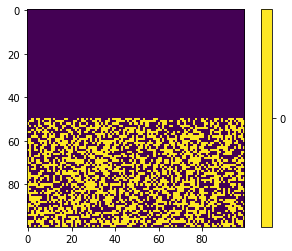

In [49]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

np.random.seed(101)
zvals = np.random.rand(100, 100) * 10
r0 = np.random.choice([-1, 1], 100**2, p=[0.5, 0.5])
r0.resize(100, 100)
r0[:50, :] = 1

# make a color map of fixed colors
cmap = colors.ListedColormap(['#FDE724', '#440154'])
bounds=[-1,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(r0, interpolation='none', cmap=cmap, norm=norm)

# make a color bar
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 5, 10])

plt.savefig('redwhite.png')
plt.show()

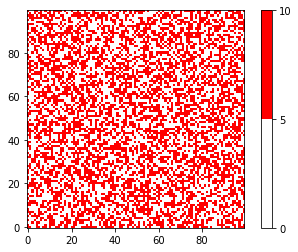

In [63]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

np.random.seed(101)
zvals = np.random.rand(100, 100) * 10

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,5,10]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(zvals, interpolation='nearest', origin='lower',
                    cmap=cmap, norm=norm)

# make a color bar
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 5, 10])

plt.savefig('redwhite.png')
plt.show()

In [25]:
np.random.rand(100, 100).shape

(100, 100)

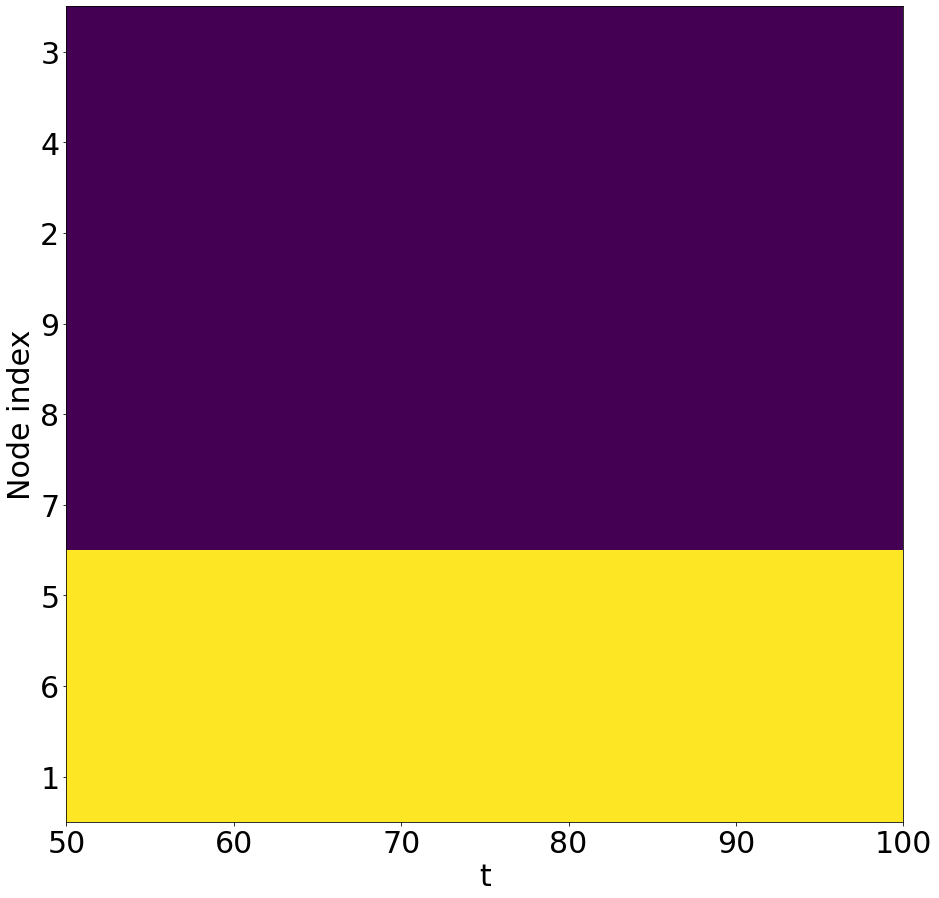

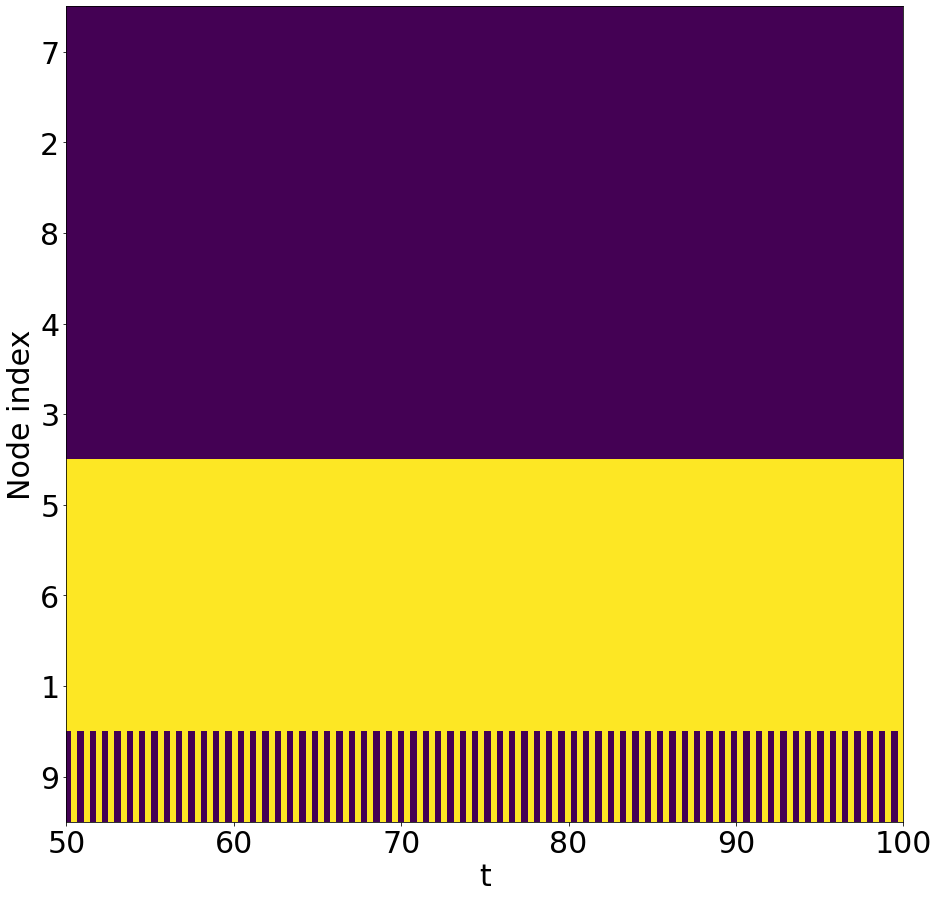

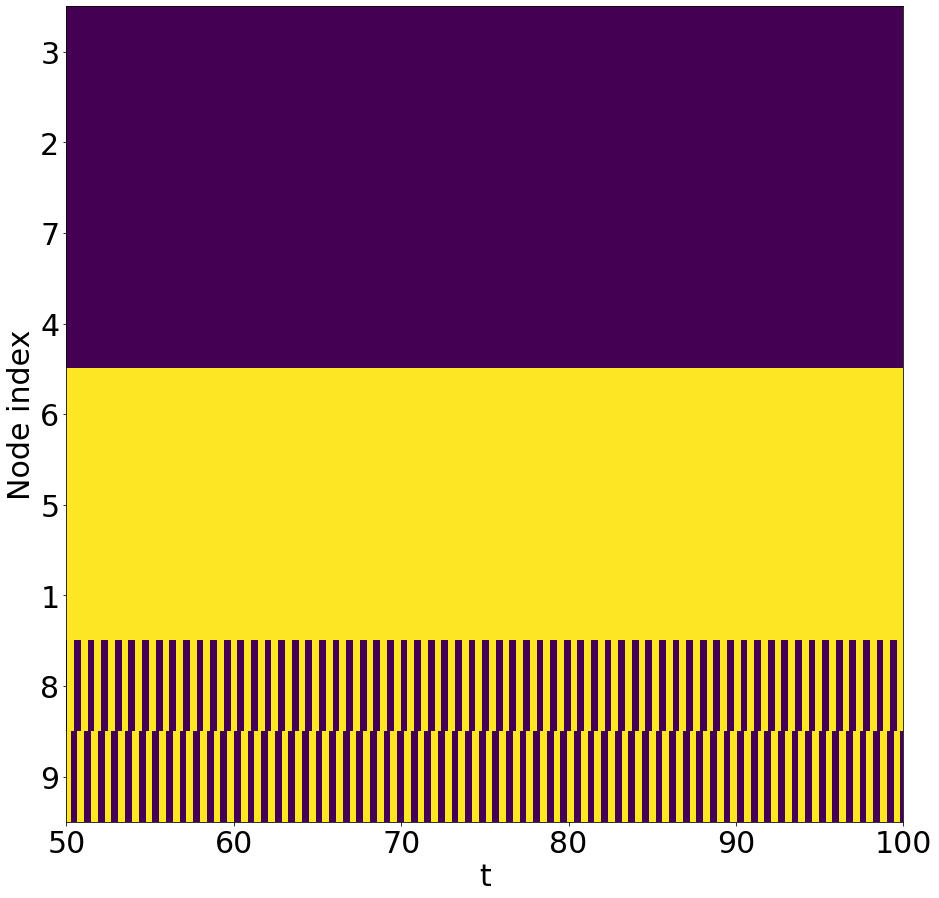

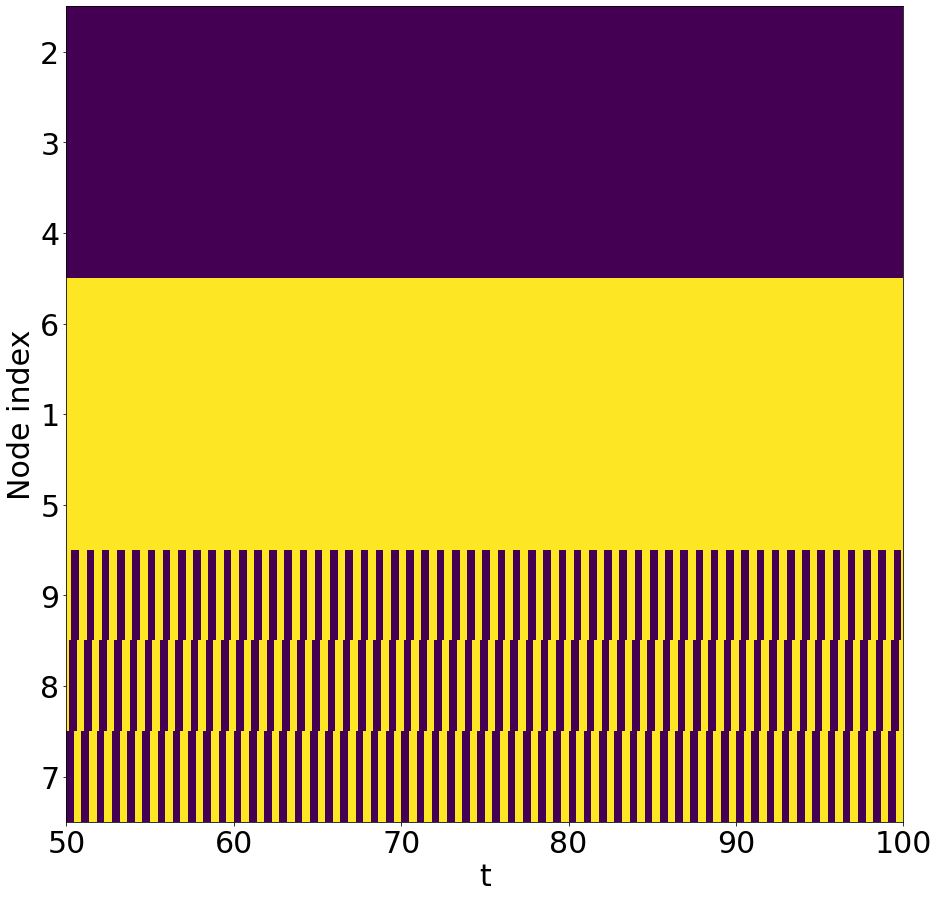

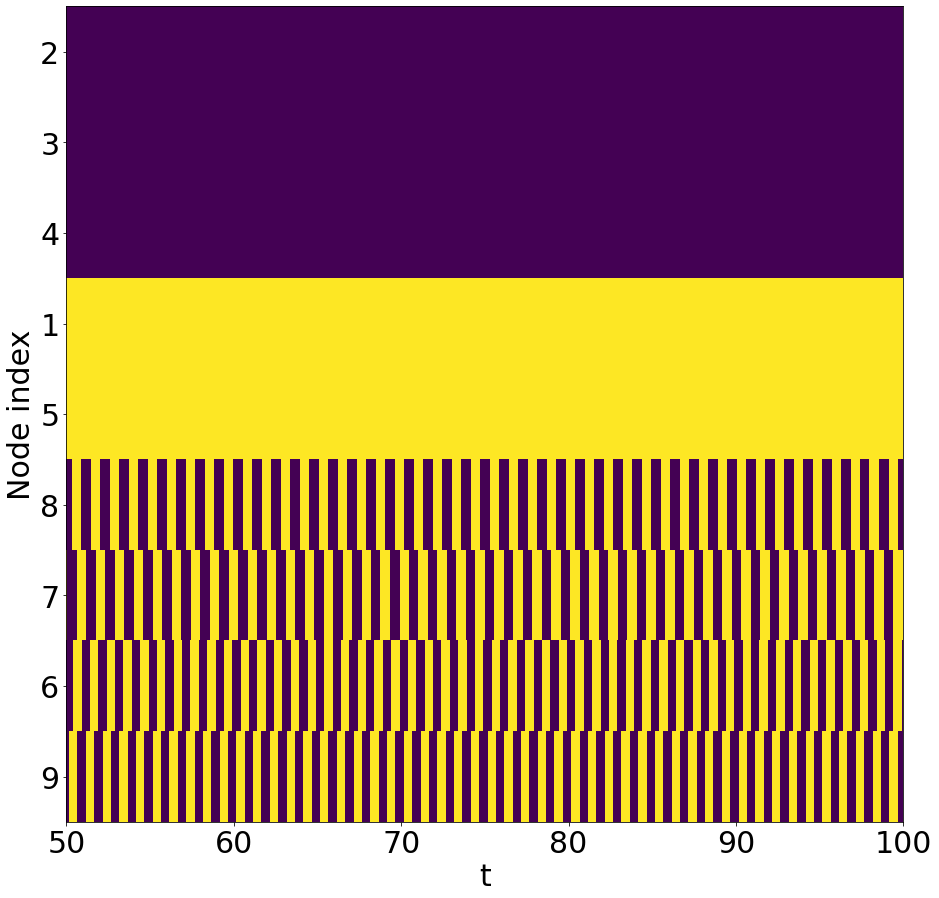

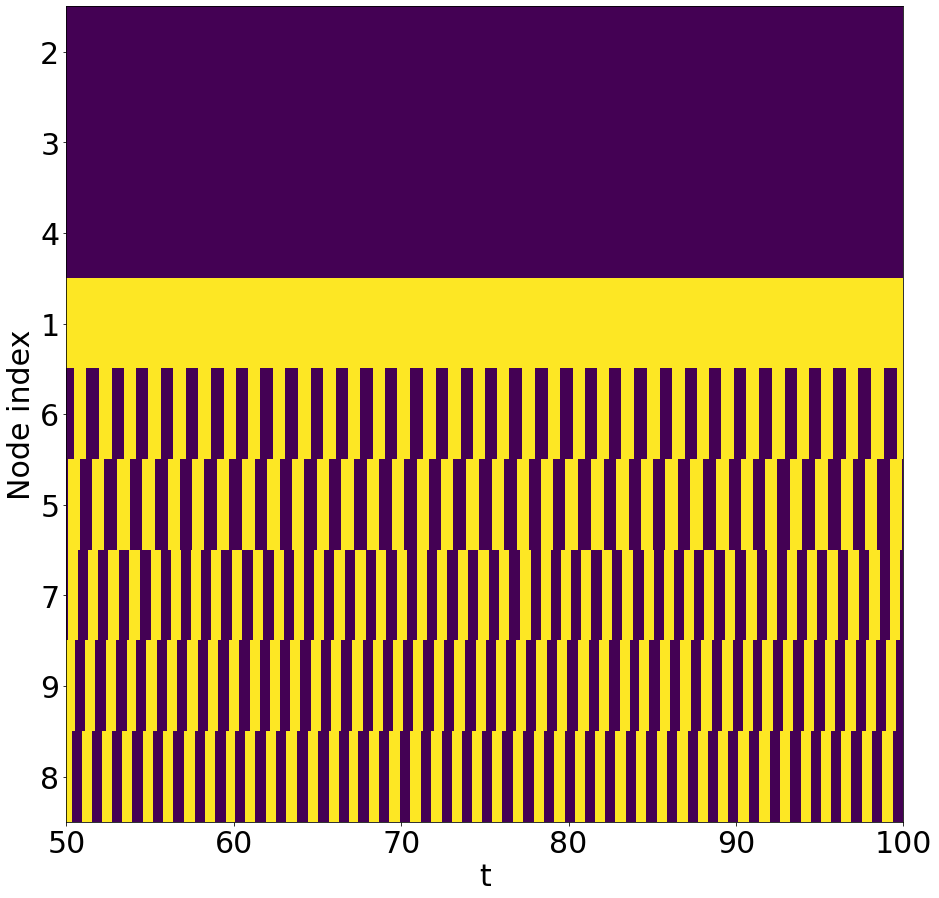

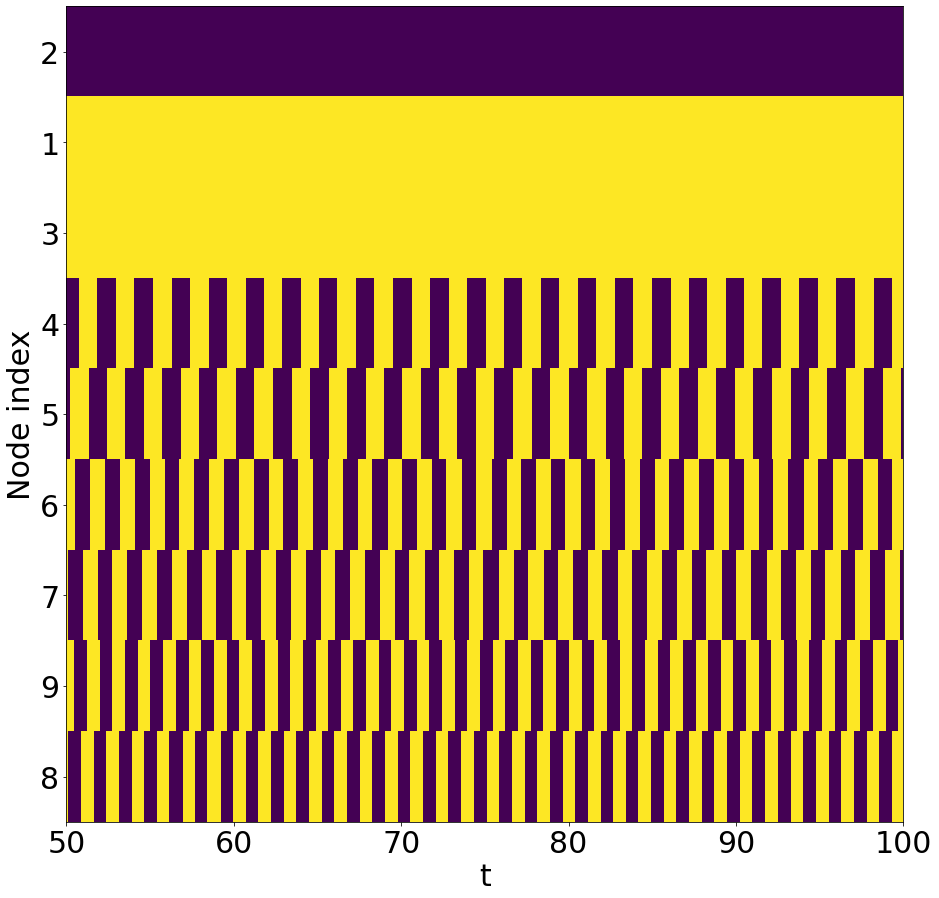

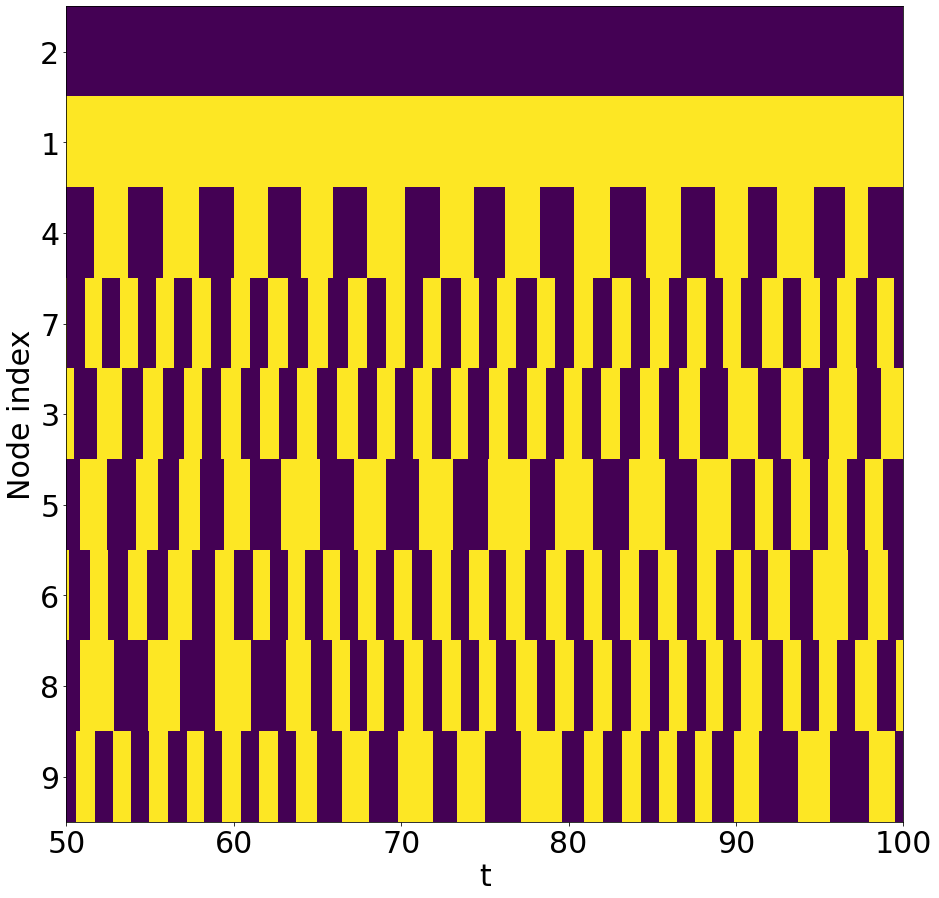

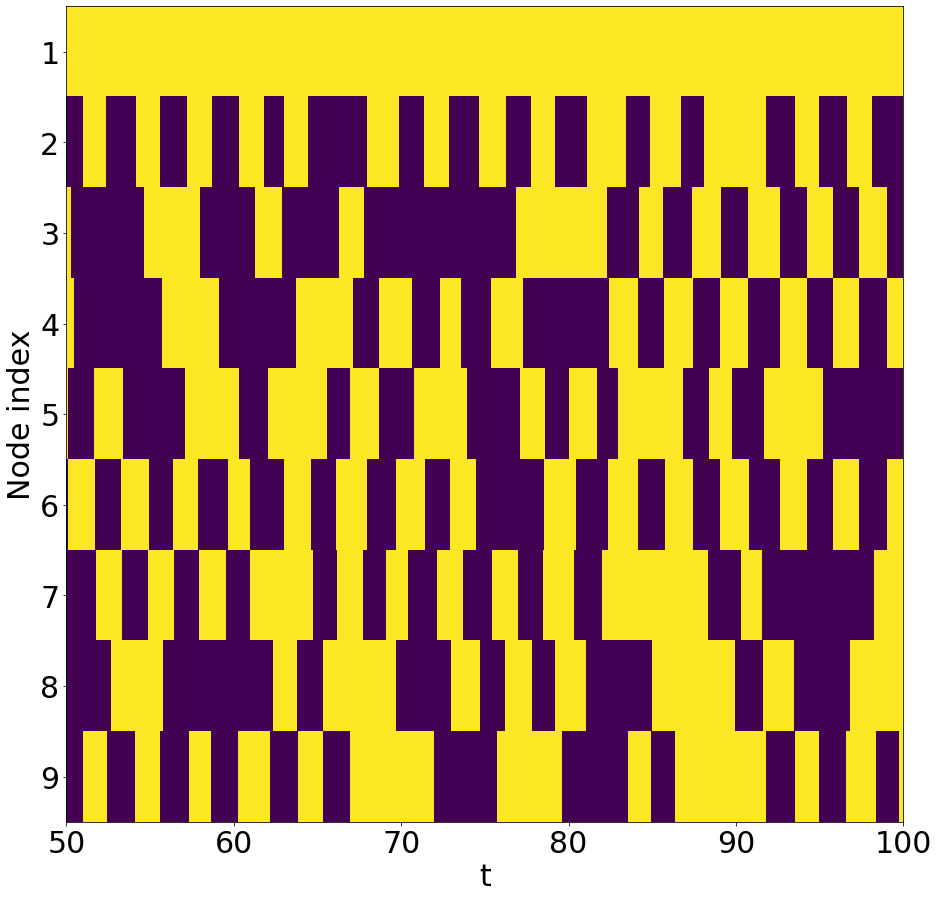

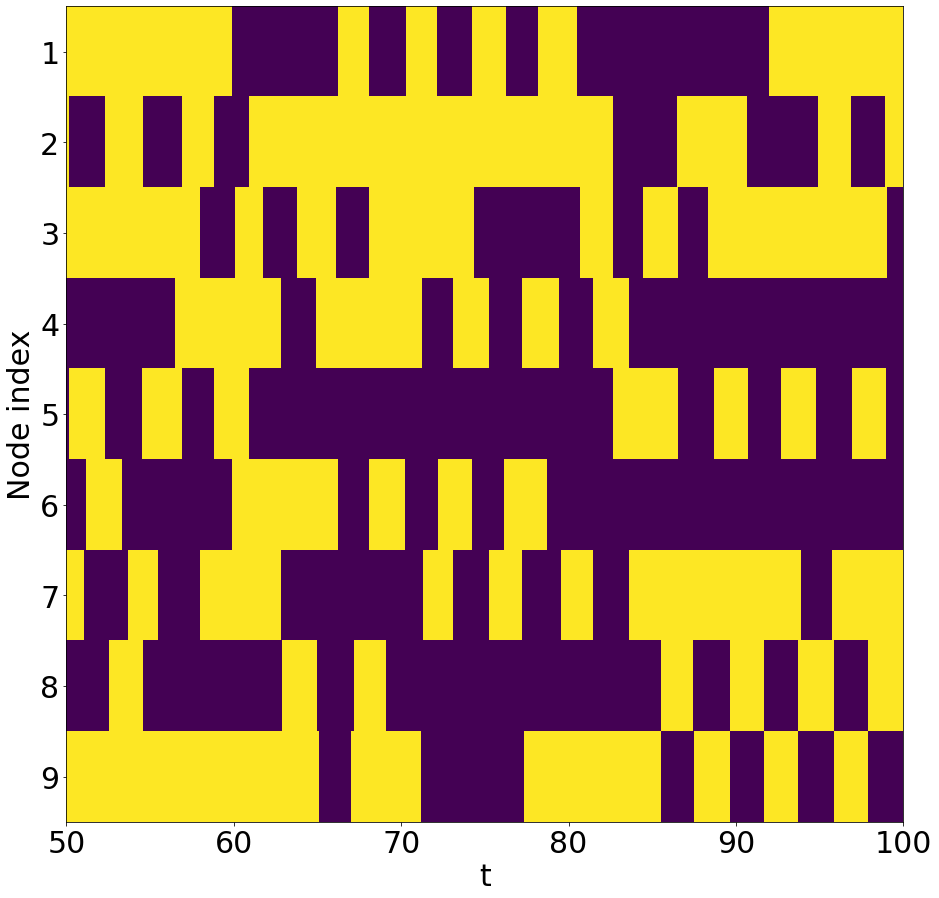

In [123]:
for n in range(10):
    fig = switching_diagram(n)
#    fig.savefig(f'Images\\synch nine D network n={n}.png', format='png')

[]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


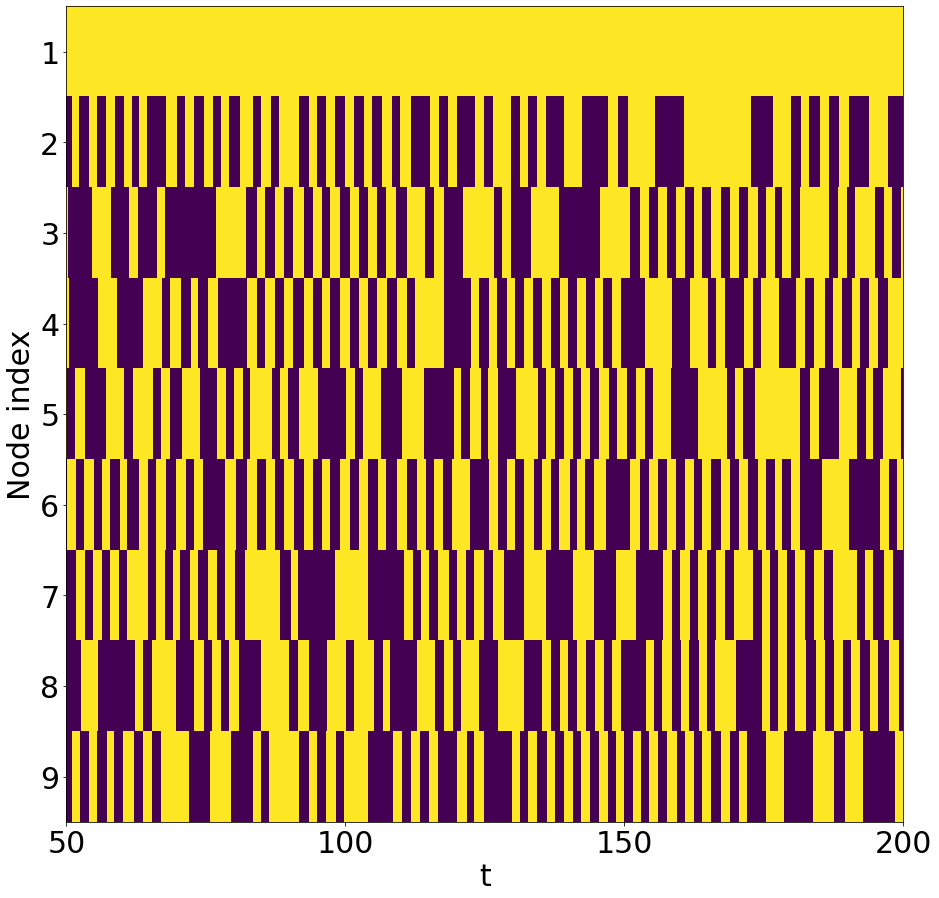

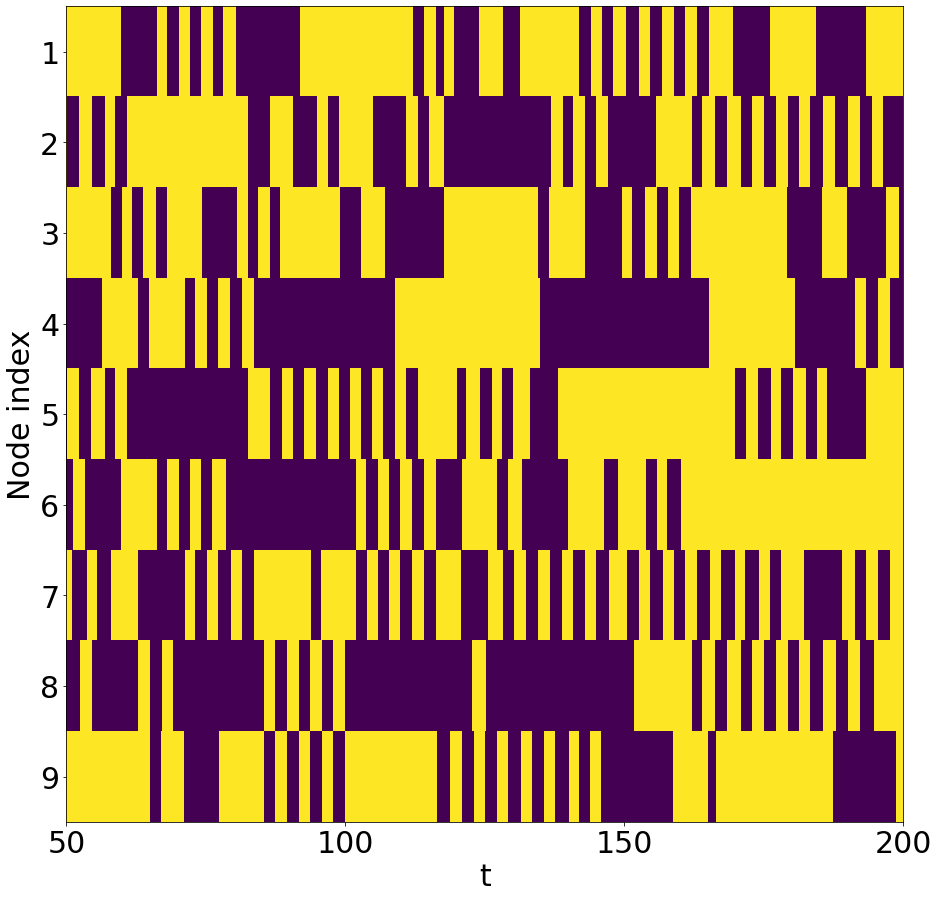

In [98]:
fig = switching_diagram_long(8, trajectories_long)
fig.savefig(f'Images\\long time synch nine D network n={8}.png', format='png')

fig = switching_diagram_long(9, trajectories_long)
fig.savefig(f'Images\\long time synch nine D network n={9}.png', format='png')

In [19]:
@widgets.interact(a=(0, 8, 1), b=(0, 8, 1),
                  c=(0, 8, 1), d=(0, 8, 1),
                  e=(0, 8, 1), f=(0, 8, 1), 
                  g=(0, 8, 1), h=(0, 8, 1),
                  i=(0, 8, 1), n=(0, 9, 1))
def update(a=0, b=1, c=2, d=3, e=4, f=5, g=6, h=7, i=8, n=0):
    fig, ax = plt.subplots(figsize=(15, 15))
    r_perm = trajectories[n, [a, b, c, d, e, f, g, h, i], :]
    neg = ax.imshow(np.sign(r_perm[:,100000:200000]), vmin=-1, vmax=1, cmap='viridis',aspect='auto', interpolation='none')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    yticks = np.arange(0, 9)
    ax.set_yticks(yticks)
    ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.yticks(fontsize=20)
    ax.set_xticks([0, 20000, 40000, 60000, 80000, 100000])
    ax.set_xticklabels([50, 60, 70, 80, 90, 100])
    plt.xticks(fontsize=20)
    ax.set_ylabel('Node index', fontsize=20)
    ax.set_xlabel('t', fontsize=20)

interactive(children=(IntSlider(value=0, description='a', max=8), IntSlider(value=1, description='b', max=8), …

In [ ]:
dt = 100/200000
(switch_times, inter_switch_times) = t_switch(trajectories[6], [100000, 150000])
node_types = classify_nodes(inter_switch_times, dt, 0.1)
periods, G = freq_clusters(node_types['periodic'], inter_switch_times, dt, 0.01)